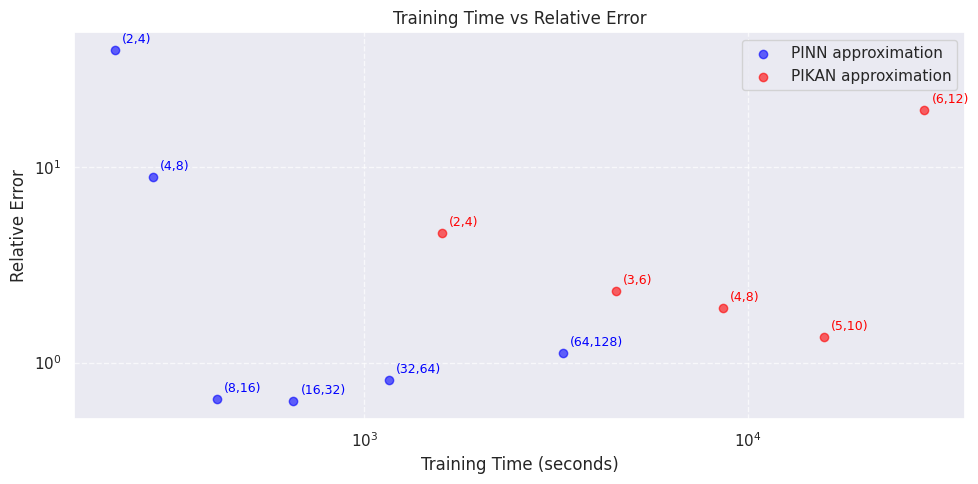

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from utils.styled_plots import plot_log
import seaborn as sns

def natural_sort_key(s):
    """Function to sort strings with numbers in natural order"""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Paths to the folders
errors_path = "results/errors"
times_path = "results/training_times"

# Lists to store our data
errors = []
times = []
labels = []

# Read all CSV files from both directories
error_files = sorted(os.listdir(errors_path), key=natural_sort_key)
time_files = sorted(os.listdir(times_path), key=natural_sort_key)

# Read error files
for file_name in error_files:
    if file_name.endswith('.csv'):
        file_path = os.path.join(errors_path, file_name)
        with open(file_path, 'r') as file:
            value = float(file.read().strip())
            errors.append(value)
            # Extract the parameters from filename (assuming format like "relative_error(8,16).csv")
            params = re.findall(r'\((\d+),(\d+)\)', file_name)
            if params:
                labels.append(f"({params[0][0]},{params[0][1]})")

# Read time files
for file_name in time_files:
    if file_name.endswith('.csv'):
        file_path = os.path.join(times_path, file_name)
        # In your file reading loop, replace:
        with open(file_path, 'r') as file:
            time_str = file.read().strip()
            value = time_to_seconds(time_str)
            times.append(value)


# Paths to the folders
errors_path2 = "results_kan/errors"
times_path2 = "results_kan/training_times"

# Lists to store our data
errors2 = []
times2 = []
labels2 = []

# Read all CSV files from both directories
error_files2 = sorted(os.listdir(errors_path2), key=natural_sort_key)
time_files2= sorted(os.listdir(times_path2), key=natural_sort_key)

# Read error files
for file_name in error_files2:
    if file_name.endswith('.csv'):
        file_path = os.path.join(errors_path2, file_name)
        with open(file_path, 'r') as file:
            value = float(file.read().strip())
            errors2.append(value)
            # Extract the parameters from filename (assuming format like "relative_error(8,16).csv")
            params = re.findall(r'\((\d+),(\d+)\)', file_name)
            if params:
                labels2.append(f"({params[0][0]},{params[0][1]})")

# Read time files
for file_name in time_files2:
    if file_name.endswith('.csv'):
        file_path = os.path.join(times_path2, file_name)
        # In your file reading loop, replace:
        with open(file_path, 'r') as file:
            time_str = file.read().strip()
            value = time_to_seconds(time_str)
            times2.append(value)
# Create the scatter plot


sns.set_theme(style="darkgrid")

plt.figure(figsize=(10, 5))

plt.scatter(times, errors, alpha=0.6, label="PINN approximation", color="blue", zorder = 2)
for i, label in enumerate(labels):
    plt.annotate(label,
                 (times[i], errors[i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=9,
                 color="blue",
                 zorder=5)

plt.scatter(times2, errors2, alpha=0.6, label="PIKAN approximation", color="red", zorder = 2)
for i, label in enumerate(labels2):
    plt.annotate(label,
                 (times2[i], errors2[i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=9,
                 color="red",
                 zorder=5)


plt.xscale('log')  # Make x-axis logarithmic
plt.yscale('log')  # Make y-axis logarithmic

plt.xlabel('Training Time (seconds)')
plt.ylabel('Relative Error')
plt.title('Training Time vs Relative Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig("errors.pdf")
plt.show()



In [2]:
def time_to_seconds(time_str):
    """Convert time string in format 'H:MM:SS.microseconds' to seconds"""
    # Split on ':' to get hours, minutes, and seconds
    parts = time_str.split(':')
    
    if len(parts) == 3:  # Format is H:MM:SS.microseconds
        hours, minutes, seconds = parts
    elif len(parts) == 2:  # Format is MM:SS.microseconds
        hours = '0'
        minutes, seconds = parts
    else:
        raise ValueError(f"Unexpected time format: {time_str}")
    
    # Convert to float
    total_seconds = (
        float(hours) * 3600 +    # hours to seconds
        float(minutes) * 60 +    # minutes to seconds
        float(seconds)           # seconds and microseconds already in seconds
    )
    
    return total_seconds





In [6]:
import numpy as np
from utils.styled_plots import plot_styled_k, plot_styled_waves

x_vals = np.linspace(-3, 3, 150)
y_vals = np.linspace(-3, 0, 150)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)

alpha = 0.5
beta = 10
epsilon = 0.75

u_true = np.exp(-alpha * (X_mesh**2 + Y_mesh**2)) * np.cos(beta * X_mesh)
k_true =  1 + 2 / (1 + np.exp(-(Y_mesh + 1.5) / epsilon))


    
figu,axu = plot_styled_waves(X_mesh, Y_mesh, u_true, title="Analytic u (Semi infinite domain)", saveas="anl/u_real_semi.pdf")
figu,axu = plot_styled_k(X_mesh, Y_mesh, k_true, title="Analytic k (Semi infinite domain)", saveas="anl/k_real_semi.pdf")

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from utils.styled_plots import plot_styled_k, plot_styled_waves

class MLP_u(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_u, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

    
class MLP_k(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_k, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x
    
model = torch.load(
    "results/models/model_u(new_try2).pth",
    map_location="cpu",
    weights_only=False
)
model.eval()
modelk = torch.load(
    "results/models/model_k(new_try2).pth",
    map_location="cpu",
    weights_only=False
)
modelk.eval()

# 3) Grid y evaluación
x = np.linspace(-3, 3, 250)
y = np.linspace(-3, 0, 250)
X, Y = np.meshgrid(x, y)

with torch.no_grad():
    coords = torch.from_numpy(np.stack([X.ravel(), Y.ravel()], axis=1)).float()
    Z = model(coords).detach().cpu().numpy().reshape(X.shape)
    K = modelk(coords).detach().cpu().numpy().reshape(X.shape)  



plot_styled_waves(X,Y,Z, title="u approximation (PINN)", saveas="anl/u_approx_semi.pdf")


(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'u approximation (PINN)'}>)

In [7]:
plot_styled_k(X,Y,K, title="k approximation (PINN)", saveas="anl/k_approx_semi.pdf")


(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'k approximation (PINN)'}>)

In [8]:
def relative_error_analytic(model_u, model_k, n_points=200, device='cuda'):
    """
    Computes the relative percentage error between model predictions and ground truth for u and k.
    
    Args:

        model_u (torch.nn.Module): Trained model predicting u(x, y).
        model_k (torch.nn.Module): Trained model predicting k(x, y).
        alpha (float): Parameter in the analytic solution of u.
        beta (float): Parameter in the analytic solution of u.
        epsilon (float): Parameter in the analytic solution of k.
        n_points (int): Number of grid points in each dimension.
        device (str): 'cpu' or 'cuda'.

    Returns:
        Tuple of relative percentage errors for u and k: (rel_error_u, rel_error_k)
    """

    # Crear la malla
    x = np.linspace(-3, 3, 250)
    y = np.linspace(-3, 0, 250)
    X, Y = np.meshgrid(x, y)

    XY_np = np.stack([X.flatten(), Y.flatten()], axis=1)

    u_pred = model_u 
    k_pred = model_k
    alpha = 0.5
    beta = 10
    epsilon = 0.75
    
    u_true = np.exp(-alpha * (X**2 + Y**2)) * np.cos(beta * X)
    k_true =  1 + 2 / (1 + np.exp(-(Y + 1.5) / epsilon))


    rel_err_u = (u_pred - u_true)
    rel_err_k = (k_pred - k_true) 

    return rel_err_k, rel_err_u


In [9]:
error_k, error_u = relative_error_analytic(Z, K, n_points=250, device='cpu')

(<Figure size 500x575 with 2 Axes>, <Axes: title={'center': 'Error k (PINN)'}>)

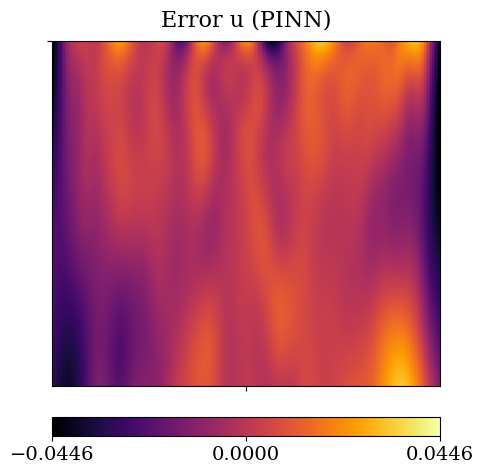

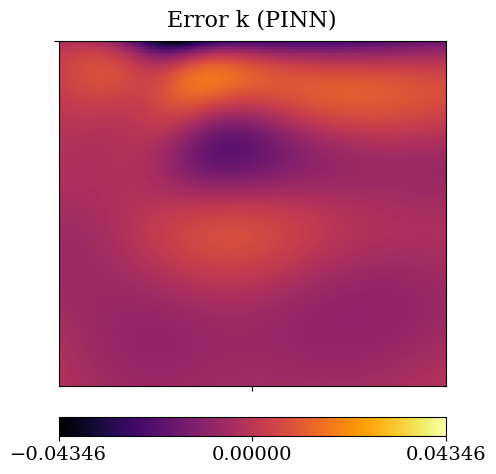

In [10]:
from utils.styled_plots import plot_styled_error

plot_styled_error(X, Y, error_u, title="Error u (PINN)", saveas="anl/error_u_pinn_semi.pdf")
plot_styled_error(X, Y, error_k, title="Error k (PINN)", saveas="anl/error_k_pinn_semi.pdf")

In [3]:
from utils.styled_plots import plot_styled_waves_sq


In [4]:
plot_styled_waves_sq(X, Y, Z, title="u generalization capability (PINN)", saveas="anl/u_general.pdf")

(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'u generalization capability (PINN)'}>)

In [5]:
from utils.styled_plots import plot_styled_k_sq
plot_styled_k_sq(X, Y, K, title="k generalization capability (PINN)", saveas="anl/k_general.pdf")

(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'k generalization capability (PINN)'}>)